# ANÁLISE CLAUSTER

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import metrics
from scipy.cluster import hierarchy
import geopandas as gp

%matplotlib inline
sns.set()

Preparando os dados

In [ ]:
df = pd.read_excel('Resultados_Analise_DEA.xlsx')

In [ ]:
data = df.loc[:,['GD','GAP','IEF']].copy()

Alguns Gráficos

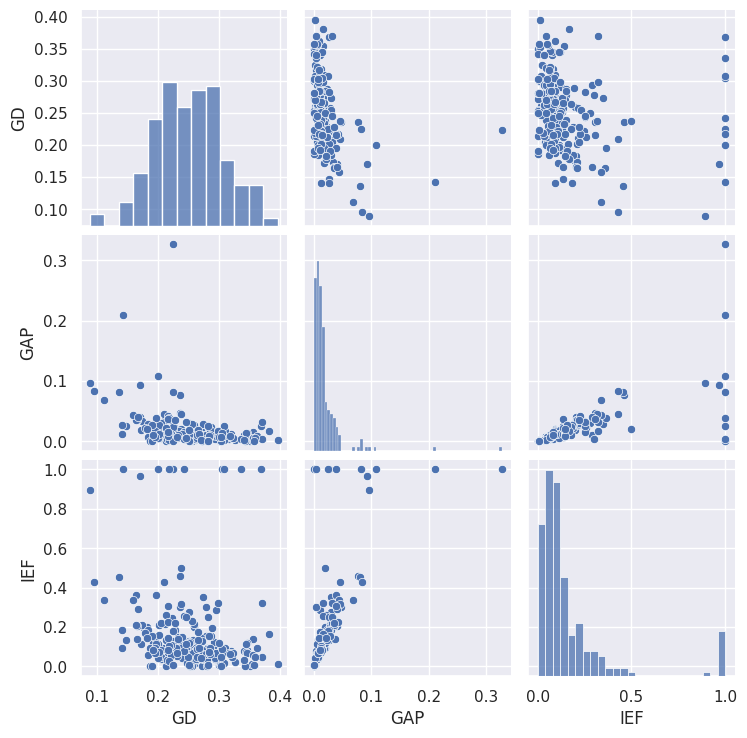

In [ ]:
sns.pairplot(data)

<Axes: >

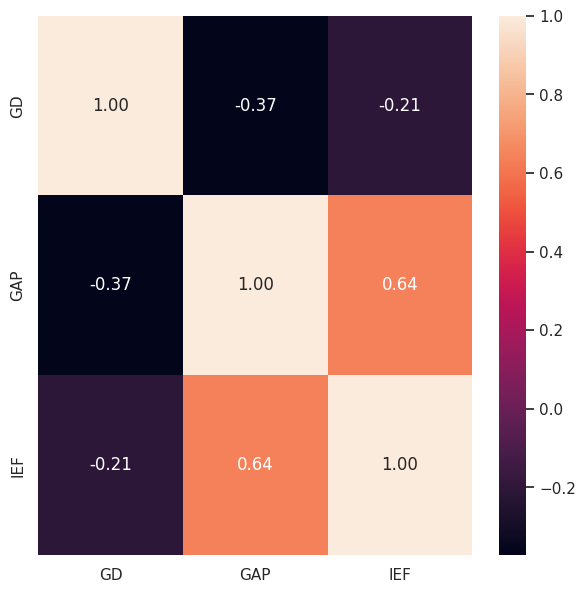

In [ ]:
plt.figure(figsize=(7, 7))
corr = np.corrcoef(data.values, rowvar=False)
sns.heatmap(corr, annot=True, fmt='.2f', cbar=True, xticklabels=data.columns, yticklabels=data.columns)

Padronizando os dados

In [ ]:
#data.iloc[:, :] = StandardScaler().fit_transform(data)

Metodo Hierárquico - Dendrograma

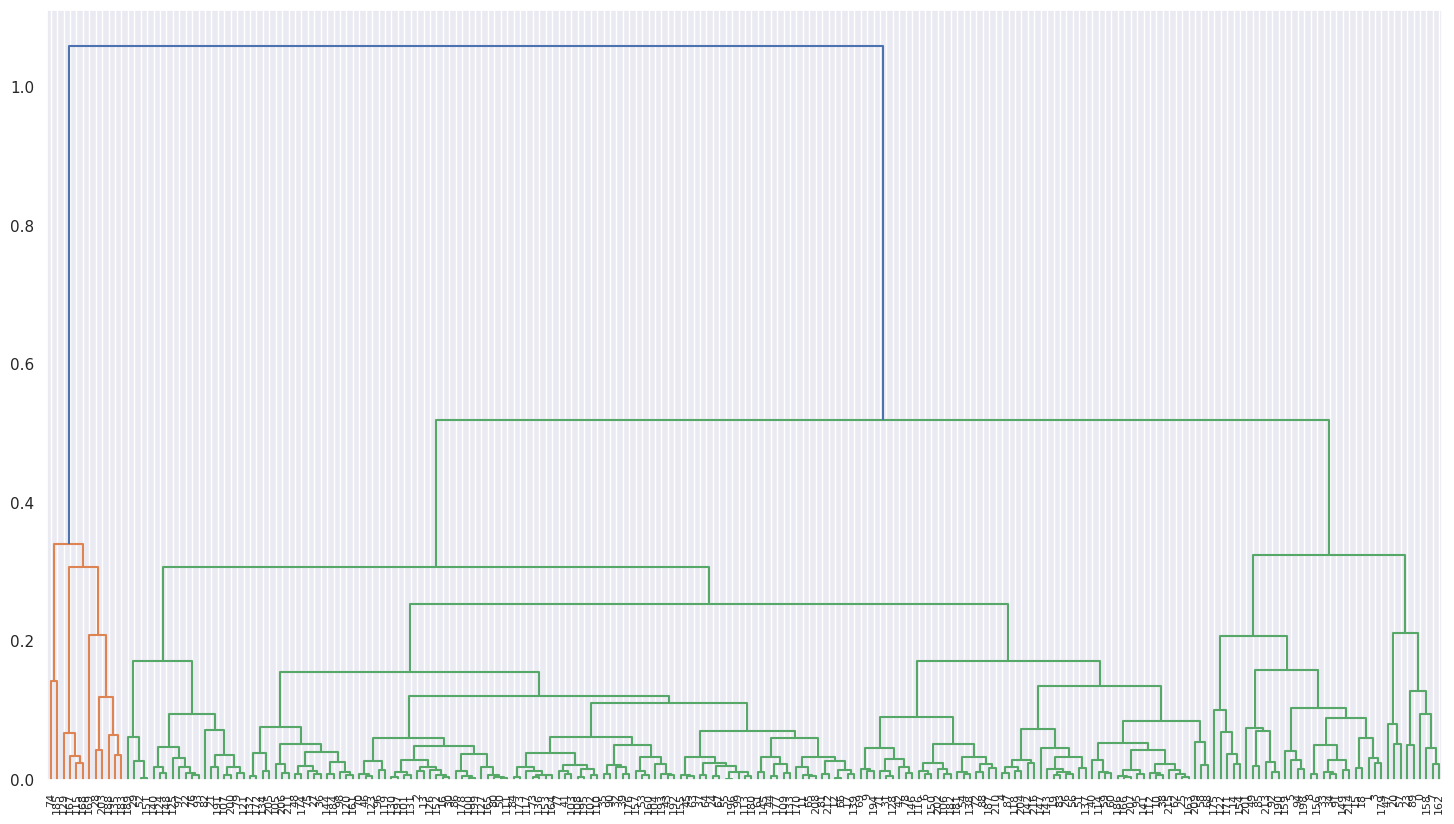

In [ ]:
Z = hierarchy.linkage(data, method = 'complete')
plt.figure(figsize=(18, 10))
plt.grid(axis='y')
dn = hierarchy.dendrogram(Z, labels=list(data.index), leaf_font_size=8)

Escolhendo um $k$ apropriado. Prmeiro plotamos o gráfico dos pontos para $k=4$

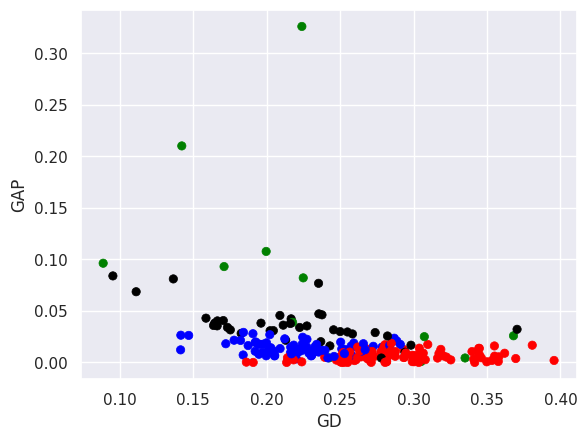

In [ ]:
fig = plt.figure()
ax = fig.subplots()
km2 = KMeans(n_clusters=4, random_state = 0, n_init='auto').fit(data)# Testando k = 2
x, y, z = data['GD'], data['IEF'], data['GAP']
cores = ['red', 'green', 'blue', 'black','olive','orange','purple','brown']

with plt.style.context('ggplot'):
  plt.scatter(x, z, c=[cores[i] for i in km2.labels_])
  ax.set_xlabel('GD')
  ax.set_ylabel('GAP')

Usando o Método do Cotovelo

In [ ]:
inercias = []
kas = []
for i in range(2,16):
  kmeans = KMeans(n_clusters=i,random_state = 0, n_init=10).fit(data)
  kas.append(i)
  inercias.append(kmeans.inertia_)

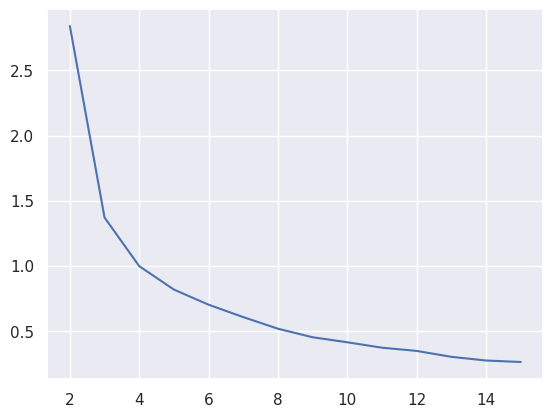

In [ ]:
plt.plot(kas, inercias)

Notamos que $k=4$ é o melhor

Agora vamos usar outra medida que pode indicar um bom $k$

Coeficiente Silhueta

In [ ]:
value_k = []
S = []
for k in range(2, 15):
  kmeans = KMeans(n_clusters = k, random_state = 0, n_init=10).fit(data)
  value_k.append(k)
  S.append(metrics.silhouette_score(data, kmeans.labels_))

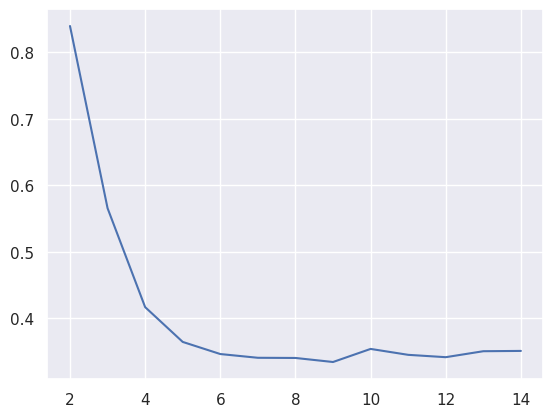

In [ ]:
fig, ax = plt.subplots()
ax.plot(value_k, S)

In [ ]:
k = 4
kmeans4 = KMeans(n_clusters = k, random_state = 0, n_init=10 )

df = df.assign(clusterk4 = kmeans4.fit_predict(data))

In [ ]:
df.to_excel('Dados_Clusterizados.xlsx')

### Estatísticas Descritivas

In [ ]:
cols = ['POP', 'VAI_pc', 'VAS_pc', 'VAA_pc', 'ARR_pc','FPM_pc', 'PIB_pc', 'GD', 'GAP', 'RP_pc', 'IEF']

In [ ]:
# crie as estatísticas descritivas para as variaveis de cols, com base no df
df_estatiscas = df[cols].describe().T

In [ ]:
df_estatiscas.to_excel("Estatíscas_Descritivas.xlsx", index_label=False)

### Obtendo um Resumo dos Grupos

In [ ]:
def localiza_grupo(df, grupo):
  df_loc = df.loc[df.clusterk4 == grupo]
  return df_loc

In [ ]:
df_est = pd.DataFrame()
for g in range(4):
  dfg = localiza_grupo(df, g)
  dfg = dfg.loc[:,'POP':'clusterk4'].describe()
  df_est = pd.concat([df_est, dfg])

df_est = df_est.T

In [ ]:
df_est.to_excel('Resumo_Grupos.xlsx', index_label = False)

# MAPA

In [ ]:
munic = gp.read_file('/content/MA_Municipios_2019.dbf')
geo = gp.read_file('/content/MA_Municipios_2019.shx')

In [ ]:
munic['CD_MUN'] = pd.to_numeric(munic['CD_MUN'])

In [ ]:
df_mun = pd.merge(munic,  df, how='left', left_on='CD_MUN', right_on='CODIGO')

In [ ]:
df_mun

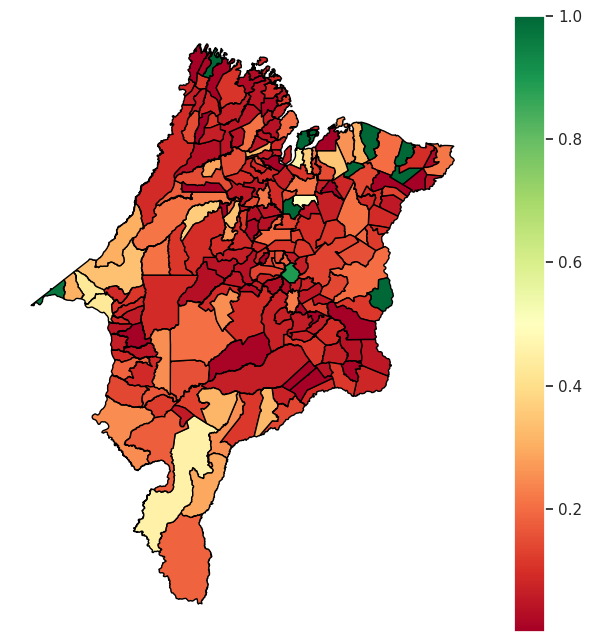

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df_mun.plot(ax=ax, column='IEF', cmap='RdYlGn',
            legend=True,
            edgecolor='black')

ax.set_axis_off()
ax.set_facecolor('white')

#plt.savefig("Distribuicao_IEF.png", dpi=300, bbox_inches='tight')

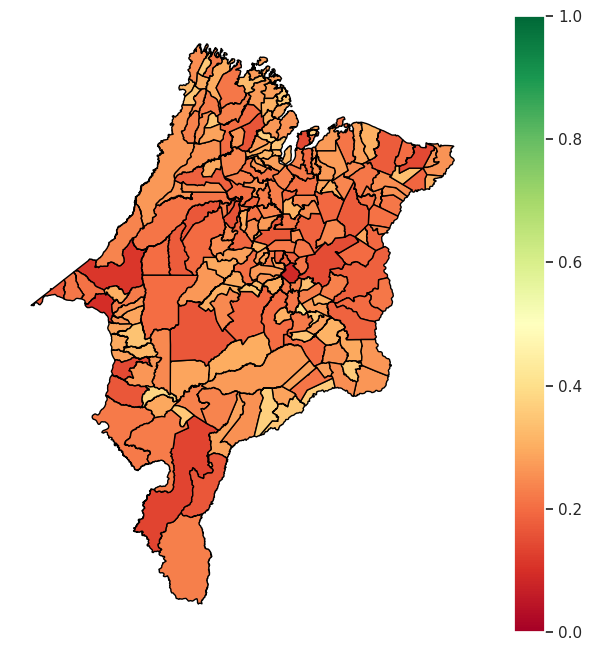

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df_mun.plot(ax=ax, column='GD', cmap='RdYlGn', legend=True,
            edgecolor='black', vmin=0, vmax=1)

ax.set_axis_off()
ax.set_facecolor('white')

#plt.savefig("Distribuicao_GD", dpi=300, bbox_inches='tight')

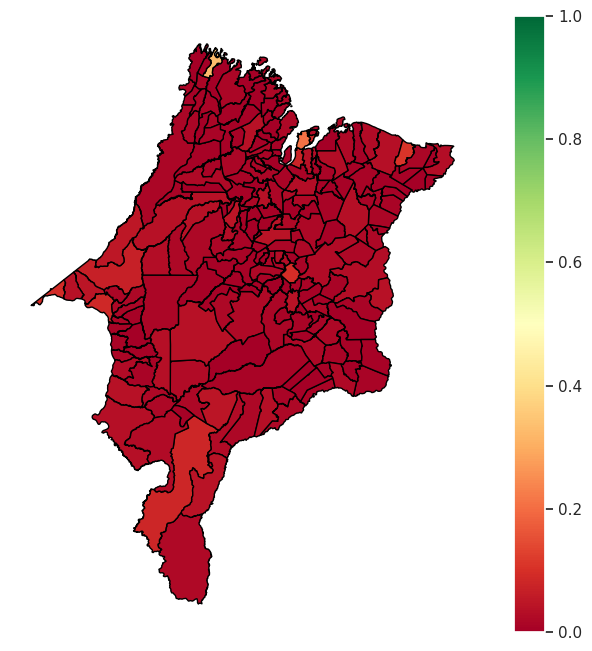

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df_mun.plot(ax=ax, column='GAP', cmap='RdYlGn', legend=True,
            edgecolor='black', vmin=0, vmax=0.5)

ax.set_axis_off()
ax.set_facecolor('white')

#plt.savefig("Distribuicao_GAP", dpi=300, bbox_inches='tight')

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

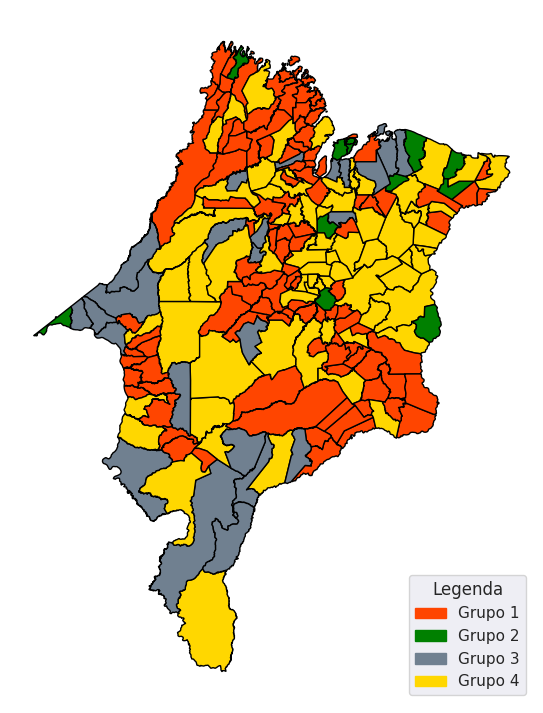

In [ ]:
legend_labels = ['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4']
colors = ['#FF4500','green','SlateGray', 'Gold']

cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(10, 9))
df_mun.plot(ax=ax, column='clusterk4', cmap=cmap,
            legend=False,
            edgecolor='black',
            vmin=0, vmax=3)

# Adicionando a legenda manualmente
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(colors))]
plt.legend(handles=patches, title='Legenda', loc='lower right')

# Adicionando a barra de cores
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=3))
sm._A = []  # Forçando a atualização da barra de cores
#cbar = plt.colorbar(sm, ax=ax)
cbar.set_ticks([0.40, 1.1, 1.9, 2.6])
cbar.set_ticklabels(legend_labels)

ax.set_axis_off()
ax.set_facecolor('white')

plt.savefig("Distribuicao_Cluster.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df_mun.loc[df_mun.clusterk4==1].count()

In [ ]:
df_mun.info()